<a href="https://colab.research.google.com/github/Sushmitha-Katti/MyBlog/blob/master/Modest/MODEST_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10997667227140751419, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14407516663023099750
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10840681827771281068
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 981351107056076314
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        #print("x1", x1)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #print("x2", x5)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #print("x", x)
        logits = self.outc(x)
        #print(logits)
        
        return logits

In [101]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = UNet(3,1).to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
        DoubleConv-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1,

In [0]:
#Extract data
import zipfile
archive = zipfile.ZipFile(f'/content/drive/My Drive/Mask_Rcnn/Dataset/data_part1.zip')
archive.extractall()

In [0]:
!git clone "https://github.com/Sushmitha-Katti/PyTNet"

fatal: destination path 'PyTNet' already exists and is not an empty directory.


In [102]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rdqysyzs
Albumentation library is successfully installed!


In [0]:
import sys
sys.path.append("PyTNet")

In [0]:
import torch
import train_test_loader
import show_images
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Range_Test import LR_test
from tinyimagenet import TinyImageNetDataSet
from Models import ResnetModel

In [0]:
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
from tqdm import notebook
# -----------------------------------------------------Main Function which calls everything--------------------------------------------------------------
def RawDataSet(train_split = 70,test_transforms = None,train_transforms = None):

  #down_url  = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
  #download_images(down_url)
  #classes = class_names(url = "tiny-imagenet-200/wnids.txt")
  dataset = Rawdata(url="/content/data_1" )
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  print(len(dataset))
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset(train_set, iptransform=train_transforms, optransform = test_transforms)
  test_dataset = DatasetFromSubset(val_set, iptransform=train_transforms, optransform = test_transforms)

  return train_dataset, test_dataset



# --------------------------------------------------------------Custom data set-------------------------------------------------------------------------

class Rawdata(Dataset):
    def __init__(self,url):
        self.data = []
        self.target = []
       
        self.url = url
        
      
        
        for i in notebook.tqdm(range(10000)):
          
         inimg = Image.open(f'{url}/Fg-Bg/fg-bg{str(i+1)}.jpg')
         innpimg = np.asarray(inimg)
         self.data.append(innpimg)  
         outimg = Image.open(f'{url}/Fg-Bg-Mask/fg-bg-mask{str(i+1)}.jpg')
         outnpimg = np.asarray(outimg)
         self.target.append(outnpimg)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.target[idx]
        img = data     
        return data,target



# ----------------------------------------------------Data subset which comes after splitting--------------------------------------------------

class DatasetFromSubset(Dataset):
    def __init__(self, subset, iptransform=None, optransform = None):
        self.subset = subset
        self.iptransform = iptransform
        self.optransform = optransform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.iptransform:
            x = self.iptransform(x)
            y = self.optransform(y)
        return x, y

    def __len__(self):
        return len(self.subset)

# -------------------------------------------------------------------------------------------------------------------------------------------------------







In [4]:
import albumentations as A
import cv2
fg_bg_means = (0.65830478, 0.61511271, 0.5740604)
fg_bg_stdevs = (0.24408717, 0.2542491, 0.26870159)
mask_means = (0)
mask_std = (255)

train_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=fg_bg_means, std=fg_bg_stdevs),
                                   
                                       ])
mask_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=mask_means, std=mask_std),
                                
                                   
                                       ])

#test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms = mask_transform,train_transforms =train_transform )

NameError: ignored

In [0]:
len(train_dataset)

7000

In [0]:
for i in train_dataset:
  i[1].unsqueeze_(-1)
  print(i[1].size())
  print(i[1].view(1,i[1].size()[0],i[1].size()[1]).size())
  #b = i[1].expand(1,64,64)
  #print(b.size())
  break

torch.Size([64, 64, 1])
torch.Size([1, 64, 64])


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=1)

In [0]:
for i,j in trainloader:
  print(i[0].shape,j[0].shape)
  break

torch.Size([3, 64, 64]) torch.Size([64, 64])


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.BCEWithLogitsLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=30, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [0]:
# -*- coding: utf-8 -*-
"""train_test.py

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1J4LTQ-OD12iNFr63m2tsU1irRfp051Ql
"""

import torch

#Training & Testing Loops
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, epoch,scheduler = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    target.unsqueeze_(0)
  
    #target = target.view(1,64,64)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
 
    y_pred = model(data)
    #print(y_pred)
    #print(y_pred[0].shape,target[0].shape,data[0].shape)
    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()
    if(scheduler):
      scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)*64*64

    pbar.set_description(f'Loss={loss.item():0.2f} Acc={100*correct/processed:0.2f}')
    
  train_losses.append(loss)
  train_acc.append(100*correct/processed)
  return train_losses,train_acc


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            target.unsqueeze_(0)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
	
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / (len(test_loader.dataset)*64*64)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses,test_acc



test_loss = []
test_acc = []
train_loss = []
train_loss = []
LR = []
train_scheduler = False

def train_model(model,device,trainloader,testloader,optimizer,criterion,EPOCHS,scheduler = False,batch_scheduler = False ,best_acc = 0,path = "/content/gdrive/My Drive/API/bestmodel.pt"):
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      LR.append(optimizer.param_groups[0]['lr'])
      train_scheduler = False

      if(batch_scheduler):
        train_scheduler = scheduler
      train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch,train_scheduler)
      
      test_loss , test_acc = test(model, device, criterion, testloader)
      if(scheduler and not batch_scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)): 
        scheduler.step()

      elif(scheduler and not batch_scheduler and  isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
        scheduler.step(test_loss[-1])
      
      
      if(test_acc[-1]>best_acc):
        print("accuracy increased, Saving model....")
        best_acc = test_acc[-1]
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': test_loss[-1],
              }, path)


 


In [110]:

train_model(model,device,trainloader,testloader,optimizer,criterion,1,scheduler,batch_scheduler=True,best_acc = 0,path = "test.pt")

EPOCH: 1 LR: 0.002


TypeError: ignored

In [0]:
torch.cuda

In [111]:
for i in testloader:
  print(i[0])
  break

Streaming output truncated to the last 5000 lines.
         [[ 6.3952e-02,  1.7680e-02,  2.6447e-01,  ...,  8.5058e-01,
            8.8143e-01,  2.2559e-03],
          [ 5.8837e-01,  6.3464e-01,  7.7346e-01,  ...,  9.1228e-01,
            9.8940e-01, -2.8592e-02],
          [ 6.9634e-01,  6.8092e-01,  7.7346e-01,  ...,  1.0357e+00,
            1.1591e+00, -1.0571e-01],
          ...,
          [-1.0620e+00, -9.2319e-01, -7.8437e-01,  ...,  3.3104e-02,
            6.3952e-02,  1.7680e-02],
          [-9.2319e-01, -1.2008e+00, -1.0003e+00,  ..., -1.3168e-02,
           -1.9826e-01, -2.1368e-01],
          [-1.4322e+00, -1.7407e+00, -2.1571e+00,  ..., -2.1368e-01,
           -1.2114e-01, -2.1368e-01]],

         [[ 1.2573e-01,  8.1942e-02,  3.1545e-01,  ...,  1.0160e+00,
            1.0452e+00,  2.1329e-01],
          [ 6.2194e-01,  6.6572e-01,  7.9707e-01,  ...,  9.8680e-01,
            1.0744e+00,  9.6537e-02],
          [ 7.2410e-01,  7.0951e-01,  7.9707e-01,  ...,  1.0014e+00,
       

KeyboardInterrupt: ignored

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

In [0]:
for i in testloader:
  output = model(i[0].to(device))
  break

In [125]:
output.squeeze_()

tensor([[-9.3005, -9.1967, -8.8232,  ..., -8.6429, -8.2285, -8.0301],
        [-8.3975, -8.1357, -8.5259,  ..., -8.8813, -8.3473, -8.2654],
        [-9.0514, -8.8219, -8.8494,  ..., -8.6530, -8.1300, -8.0569],
        ...,
        [-8.0534, -7.7616, -8.1269,  ..., -8.4539, -8.2163, -8.3561],
        [-8.1420, -7.5156, -7.7713,  ..., -8.3329, -8.1391, -7.8736],
        [-8.5012, -8.6106, -8.4932,  ..., -8.0721, -7.9520, -8.5121]],
       device='cuda:0', grad_fn=<SqueezeBackward2>)

In [0]:
b = output.cpu().detach().numpy()


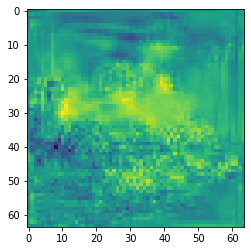

In [132]:
import matplotlib.pyplot as plt
plt.imshow(b)


In [2]:
for i in testloader:
  c = i[1]
  break

NameError: ignored

In [1]:
f = c.numpy()
plt.imshow(f)

NameError: ignored